Okay, so if you compare plot_in_out_flux here to the one in analysis.py, it's the one I've changed the most.  Everything it needs to run has been copied into a cell here.
<br><br>
The original gives an error when it tries to call get_waste_dict.  If you look at the original, it tries to index the transaction dictionary in a way that isn't allowed.  Also, from i can tell, it accidentally gave mass and time in the wrong order.
<br><br>
To try and fix it, I added a loop that pulls out the time and mass portions and puts them into an array (called mass and time in the function)
<br><br>
My original tests to try and fix this are in a cell in the lower portions - it's pretty long and prints the transactions dictionary, then makes an array called doingmybest.<br>
doingmybest is in the general form of [ [(time,mass),(time,mass)...],[(time,mass),(time,mass)...]...]

In [1]:

import collections
import numpy as np
import matplotlib.pyplot as plt
import sqlite3 as lite
import sys
from itertools import cycle
import matplotlib
from matplotlib import cm
from pyne import nucname

import analysis

In [2]:
def get_cursor(file_name):
    """Connects and returns a cursor to an sqlite output file
    Parameters
    ----------
    file_name: str
        name of the sqlite file
    Returns
    -------
    sqlite cursor3
    """
    con = lite.connect(file_name)
    con.row_factory = lite.Row
    return con.cursor()

In [3]:
def get_agent_ids(cur, archetype):
    """Gets all agentIds from Agententry table for wanted archetype
        agententry table has the following format:
            SimId / AgentId / Kind / Spec /
            Prototype / ParentID / Lifetime / EnterTime
    Parameters
    ----------
    cur: cursor
        sqlite cursor3
    archetype: str
        agent's archetype specification
    Returns
    -------
    id_list: list
        list of all agentId strings
    """
    agents = cur.execute("SELECT agentid FROM agententry WHERE spec "
                         "LIKE '%" + archetype + "%' COLLATE NOCASE"
                         ).fetchall()

    return list(str(agent['agentid']) for agent in agents)


In [4]:
def get_prototype_id(cur, prototype):
    """Returns agentid of a prototype
    Parameters
    ----------
    cur: sqlite cursor
        sqlite cursor
    prototype: str
        name of prototype
    Returns
    -------
    agent_id: list
        list of prototype agent_ids as strings
    """
    ids = cur.execute('SELECT agentid FROM AgentEntry '
                      'WHERE prototype = "' +
                      str(prototype) + '" COLLATE NOCASE').fetchall()

    return list(str(agent['agentid']) for agent in ids)


In [5]:
def facility_commodity_flux_isotopics(cur, agent_ids,
                                      commod_list, is_outflux, is_cum=True):
    """Returns timeseries isotoptics of commodity in/outflux
    from agents
    Parameters
    ----------
    cur: sqlite cursor
        sqlite cursor
    agent_ids: list
        list of agentids
    commod_list: list
        list of commodities
    is_outflux: bool
        gets outflux if True, influx if False
    is_cum: bool
        gets cumulative timeseris if True, monthly value if False
    Returns
    -------
    iso_dict: dictionary
        dictionary with "key=isotope, and
        value=timeseries list of masses in kg"
    """
    init_year, init_month, duration, timestep = get_timesteps(cur)
    iso_dict = collections.defaultdict(list)
    for comm in commod_list:
        query = ('SELECT time, sum(quantity)*massfrac, nucid '
                 'FROM transactions INNER JOIN resources '
                 'ON resources.resourceid = transactions.resourceid '
                 'LEFT OUTER JOIN compositions '
                 'ON compositions.qualid = resources.qualid '
                 'WHERE (receiverid = ' +
                 ' OR receiverid = '.join(agent_ids) +
                 ') AND (commodity = "' + str(comm) +
                 '") GROUP BY time, nucid')
        # outflux changes receiverid to senderid
        if is_outflux:
            query = query.replace('receiverid', 'senderid')

        res = cur.execute(query).fetchall()
        for time, amount, nucid in res:
            iso_dict[nucname.name(nucid)].append((time, amount))
    for key in iso_dict:
        if is_cum:
            iso_dict[key] = get_timeseries_cum(iso_dict[key], duration, True)
        else:
            iso_dict[key] = get_timeseries(iso_dict[key], duration, True)
    return iso_dict

In [6]:
cur = get_cursor('singlereactor.sqlite')

In [7]:
p_agent_ids = get_prototype_id(cur,'NuclearRepository')
print(p_agent_ids)

['27']


In [8]:
def plot_in_out_flux(cur, facility, influx_bool, title, outputname, is_cum = False):
    """plots timeseries influx/ outflux from facility name in kg.
    Parameters
    ----------
    cur: sqlite cursor
        sqlite cursor
    facility: str
        facility name
    influx_bool: bool
        if true, calculates influx,
        if false, calculates outflux
    title: str
        title of the multi line plot
    outputname: str
        filename of the multi line plot file
    is_cum: Boolean:
        true: add isotope masses over time
        false: do not add isotope masses at each timestep
    Returns
    -------
    """
    agent_ids = get_prototype_id(cur, facility)
    if influx_bool is True:
        resources = cur.execute(exec_string(agent_ids,
                                            'transactions.receiverId',
                                            'time, sum(quantity), '
                                            'qualid') +
                                ' GROUP BY time, qualid').fetchall()
    else:
        resources = cur.execute(exec_string(agent_ids,
                                            'transactions.senderId',
                                            'time, sum(quantity), '
                                            'qualid') +
                                ' GROUP BY time, qualid').fetchall()

    compositions = cur.execute('SELECT qualid, nucid, massfrac '
                               'FROM compositions').fetchall()

    init_year, init_month, duration, timestep = get_timesteps(cur)
    transactions = get_isotope_transactions(resources, compositions)
    
    inbetween =[]

    for key in transactions.keys():

        inbetween.append(transactions[key])
    
    mass = []
    time = []
    for element in range(len(inbetween)):

        for index in range(len(inbetween[element])):
            
            time.append(inbetween[element][index][0])
            mass.append(inbetween[element][index][1])
    
    waste_dict = get_waste_dict(transactions.keys(),
                                mass,
                                time,
                                duration)
    if is_cum == True:
        value = 0
        keys = []
        for key in waste_dict.keys():
            keys.append(key)

        for element in range(len(waste_dict.keys())):
            placeholder =[]
            value = 0
            key = keys[element]
            
            for index in range(len(waste_dict[key])):
                value += waste_dict[key][index]
                placeholder.append(value)
            waste_dict[key] = placeholder

    if influx_bool is False:
        stacked_bar_chart(waste_dict, timestep,
                          'Years', 'Mass [kg]',
                          title, outputname, init_year)
    else:
        combined_line_plot(waste_dict, timestep,
                        'Years', 'Mass [kg]',
                        title, outputname, init_year)


In [9]:
def multiple_line_plots(dictionary, timestep,
                        xlabel, ylabel, title,
                        outputname, init_year):
    """Creates multiple line plots of timestep vs dictionary
    Parameters
    ----------
    dictionary: dictionary
        dictionary with "key=description of timestep, and
        value=list of timestep progressions"
    timestep: numpy linspace
        timestep of simulation
    xlabel: str
        xlabel of plot
    ylabel: str
        ylabel of plot
    title: str
        title of plot
    init_year: int
        initial year of simulation
    Returns
    -------
    """
    # set different colors for each bar
    color_index = 0
    # for every country, create bar chart with different color
    for key in dictionary:
        # label is the name of the nuclide (converted from ZZAAA0000 format)
        if isinstance(key, str) is True:
            label = key.replace('_government', '')
        else:
            label = str(key)

        plt.plot(timestep_to_years(init_year, timestep),
                 dictionary[key],
                 label=label)
        color_index += 1
        if sum(sum(dictionary[k]) for k in dictionary) > 1000:
            ax = plt.gca()
            ax.get_yaxis().set_major_formatter(
                plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
        plt.ylabel(ylabel)
        plt.title(title)
        plt.xlabel(xlabel)
        plt.legend(loc=(1.0, 0), prop={'size': 10})
        plt.grid(True)
        plt.savefig(label + '_' + outputname + '.png',
                    format='png',
                    bbox_inches='tight')
    plt.close()

In [10]:
def combined_line_plot(dictionary, timestep,
                       xlabel, ylabel, title,
                       outputname, init_year):
    """Creates a combined line plot of timestep vs dictionary
    Parameters
    ----------
    dictionary: dictionary
        dictionary with "key=description of timestep, and
        value=list of timestep progressions"
    timestep: numpy linspace
        timestep of simulation
    xlabel: str
        xlabel of plot
    ylabel: str
        ylabel of plot
    title: str
        title of plot
    init_year: int
        initial year of simulation
    Returns
    -------
    """
    # set different colors for each bar
    color_index = 0
    plt.figure()
    # for every country, create bar chart with different color
    for key in dictionary:
        # label is the name of the nuclide (converted from ZZAAA0000 format)
        if isinstance(key, str) is True:
            label = key.replace('_government', '')
        else:
            label = str(key)

        plt.plot(timestep_to_years(init_year, timestep),
                 dictionary[key],
                 label=label,
                 color=cm.viridis(float(color_index) / len(dictionary)))
        color_index += 1

    if sum(sum(dictionary[k]) for k in dictionary) > 1000:
        ax = plt.gca()
        ax.get_yaxis().set_major_formatter(
            plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
    plt.ylabel(ylabel)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.legend(loc=(1.0, 0), prop={'size': 10})
    plt.grid(True)
    plt.savefig(label + '_' + outputname + '.png',
                format='png',
                bbox_inches='tight')
    plt.close()



In [11]:
def stacked_bar_chart(dictionary, timestep,
                      xlabel, ylabel, title,
                      outputname, init_year):
    """Creates stacked bar chart of timstep vs dictionary
    Parameters
    ----------
    dictionary: dictionary
        dictionary with value: timeseries data
    timestep: numpy linspace
        list of timestep (x axis)
    xlabel: str
        xlabel of plot
    ylabel: str
        ylabel of plot
    title: str
        title of plot
    init_year: int
        simulation start year
    Returns
    -------
    """
    # set different colors for each bar
    color_index = 0
    top_index = True
    prev = np.zeros(1)
    plot_list = []
    # for every country, create bar chart with different color
    for key in dictionary:
        if isinstance(key, str) is True:
            label = key.replace('_government', '')
        else:
            label = str(key)
        # very first country does not have a 'bottom' argument
        if sum(dictionary[key]) == 0:
            print(label + ' has no values')
        elif top_index is True:
            plot = plt.bar(x=timestep_to_years(init_year, timestep),
                           height=dictionary[key],
                           width=0.5,
                           color=cm.viridis(
                float(color_index) / len(dictionary)),
                edgecolor='none',
                label=label)
            prev = dictionary[key]
            top_index = False
            plot_list.append(plot)

        # All curves except the first have a 'bottom'
        # defined by the previous curve
        else:
            plot = plt.bar(x=timestep_to_years(init_year, timestep),
                           height=dictionary[key],
                           width=0.5,
                           color=cm.viridis(
                float(color_index) / len(dictionary)),
                edgecolor='none',
                bottom=prev,
                label=label)
            prev = np.add(prev, dictionary[key])
            plot_list.append(plot)

        color_index += 1

    # plot
    if sum(sum(dictionary[k]) for k in dictionary) > 1000:
        ax = plt.gca()
        ax.get_yaxis().set_major_formatter(
            plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
    plt.ylabel(ylabel)
    plt.title(title)
    plt.xlabel(xlabel)
    axes = plt.gca()
    if len(dictionary) > 1:
        plt.legend(loc=(1.0, 0))
    plt.grid(True)
    plt.savefig(outputname + '.png', format='png', bbox_inches='tight')
    plt.close()

In [12]:
def exec_string(in_list, search, request_colmn):
    """Generates sqlite query command to select things and
        inner join resources and transactions.
    Parameters
    ----------
    in_list: list
        list of items to specify search
        This variable will be inserted as sqlite
        query arugment following the search keyword
    search: str
        criteria for in_list search
        This variable will be inserted as sqlite
        query arugment following the WHERE keyword
    request_colmn: str
        column (set of values) that the sqlite query should return
        This variable will be inserted as sqlite
        query arugment following the SELECT keyword
    Returns
    -------
    str
        sqlite query command.
    """
    if len(in_list) == 0:
        raise Exception('Cannot create an exec_string with an empty list')
    if type(in_list[0]) == str:
        in_list = ['"' + x + '"' for x in in_list]

    query = ("SELECT " + request_colmn +
             " FROM resources INNER JOIN transactions"
             " ON transactions.resourceid = resources.resourceid"
             " WHERE (" + str(search) + ' = ' + str(in_list[0])
             )
    for item in in_list[1:]:
        query += ' OR ' + str(search) + ' = ' + str(item)
    query += ')'

    return query

In [13]:
def timestep_to_years(init_year, timestep):
    """Returns list of years in simulation
    Parameters
    ----------
    init_year: int
        initial year in simulation
    timestep: np.array
        timestep of simulation (months)
    Returns
    -------
    array of years
    """

    return init_year + (timestep / 12)


In [14]:
def get_timesteps(cur):
    """Returns simulation start year, month, duration and
    timesteps (in numpy linspace).
    Parameters
    ----------
    cur: sqlite cursor
        sqlite cursor
    Returns
    -------
    init_year: int
        start year of simulation
    init_month: int
        start month of simulation
    duration: int
        duration of simulation
    timestep: list
        linspace up to duration
    """
    info = cur.execute('SELECT initialyear, initialmonth, '
                       'duration FROM info').fetchone()
    init_year = info['initialyear']
    init_month = info['initialmonth']
    duration = info['duration']
    timestep = np.linspace(0, duration - 1, num=duration)

    return init_year, init_month, duration, timestep

In [15]:
def get_isotope_transactions(resources, compositions):
    """Creates a dictionary with isotope name, mass, and time
    Parameters
    ----------
    resources: list of tuples
        resource data from the resources table
        (times, sum(quantity), qualid)
    compositions: list of tuples
        composition data from the compositions table
        (qualid, nucid, massfrac)
    Returns
    -------
    transactions: dictionary
        dictionary with "key=isotope, and
        value=list of tuples (time, mass_moved)
    """
    transactions = collections.defaultdict(list)
    for res in resources:
        for comp in compositions:
            if res['qualid'] == comp['qualid']:
                transactions[comp['nucid']].append((res['time'],
                                                    res['sum(quantity)'] *
                                                    comp['massfrac']))

    return transactions

In [16]:
def get_waste_dict(isotope_list, mass_list, time_list, duration):
    """Given an isotope, mass and time list, creates a dictionary
       With key as isotope and time series of the isotope mass.
    Parameters
    ----------
    isotope_list: list
        list with all the isotopes from resources table
    mass_list: list
        list with all the mass values from resources table
    time_list: list
        list with all the time values from resources table
    duration: int
        simulation duration
    Returns
    -------
    waste_dict: dictionary
        dictionary with "key=isotope, and
        value=mass timeseries of each unique isotope"
    """

    waste_dict = collections.OrderedDict()
    isotope_set = set(isotope_list)
    for iso in isotope_set:
        mass = 0
        time_mass = []
        # at each timestep,
        for i in range(0, duration):
            # for each element in database,
            for x, y in enumerate(isotope_list):
                if i == time_list[x] and y == iso:
                    mass += mass_list[x]
            time_mass.append(mass)
        waste_dict[iso] = time_mass

    return waste_dict

In [17]:
resources = cur.execute(analysis.exec_string(p_agent_ids,
                                            'transactions.receiverId',
                                            'time, sum(quantity), '
                                            'qualid') +
                                ' GROUP BY time, qualid').fetchall()

In [18]:
compositions = cur.execute('SELECT qualid, nucid, massfrac '
                               'FROM compositions').fetchall()


In [19]:
transactions = get_isotope_transactions(resources, compositions)


In [20]:
## testing potential fixes for plot_in_out's error in calling get_waste_dict

print(transactions)
print()
print()


doingmybest =[]

for key in transactions.keys():

    doingmybest.append(transactions[key])
    
print(doingmybest)
print()
print()

mass = []
time =[]

print(doingmybest[0])
print()
print()
print(doingmybest[0][0])
print()
print()
print(doingmybest[0][0][0])
print()
print()

for element in range(len(doingmybest)):

    for index in range(len(doingmybest[element])):
        
        mass.append(doingmybest[element][index][1])
        time.append(doingmybest[element][index][0])
        
print(mass)
print()
print()
print(time)

#here is what I did to try and fix plot_in_out flux.  from the help documentation in get_wste_dict, what I made for
#mass and time might be what it expects, I'm having some trouble telling.
# looking at doingmybest, it has each "value" array as a separate element - and it stays in the correct
# isotope order.  i wonder if get_waste dict could be modified to just take transactions.keys and doingmybest (renamed
# for use in the actual function) and work with that instead?

defaultdict(<class 'list'>, {551370000: [(19, 1320.0), (21, 1320.0), (23, 1320.0), (25, 1320.0), (27, 1320.0), (38, 1320.0), (40, 1320.0), (42, 1320.0), (44, 1320.0), (46, 1320.0), (57, 1320.0), (59, 1320.0), (61, 1320.0), (63, 1320.0), (65, 1320.0), (76, 1320.0), (78, 1320.0), (80, 1320.0), (82, 1320.0), (84, 1320.0), (95, 1320.0), (97, 1320.0), (99, 1320.0), (101, 1320.0), (103, 1320.0), (114, 1320.0), (116, 1320.0), (118, 1320.0), (120, 1320.0), (122, 1320.0), (133, 1320.0), (135, 1320.0), (137, 1320.0), (139, 1320.0), (141, 1320.0), (152, 1320.0), (154, 1320.0), (156, 1320.0), (158, 1320.0), (160, 1320.0), (171, 1320.0), (173, 1320.0), (175, 1320.0), (177, 1320.0), (179, 1320.0), (190, 1320.0), (192, 1320.0), (194, 1320.0), (196, 1320.0), (198, 1320.0), (209, 1320.0), (211, 1320.0), (213, 1320.0), (215, 1320.0), (217, 1320.0), (228, 1320.0), (230, 1320.0), (232, 1320.0), (234, 1320.0), (236, 1320.0), (247, 1320.0), (249, 1320.0), (251, 1320.0), (253, 1320.0), (255, 1320.0), (266, 1

In [21]:
init_year, init_month, duration, timestep = get_timesteps(cur)

In [22]:
waste_dict = get_waste_dict(transactions.keys(),
                                mass,
                                time,
                                duration)

In [23]:
#here i printed transactions and waste_dict to compare them.  waste_dict does separate itself into 4 groups,
#but it doesn't have the right values - the "mass" is always the mass for cs137, and it doesn't have mass = 0 values
# everywhere it needs to.

print(transactions)
print()
print()

print(waste_dict)
waste_dict[551370000]

defaultdict(<class 'list'>, {551370000: [(19, 1320.0), (21, 1320.0), (23, 1320.0), (25, 1320.0), (27, 1320.0), (38, 1320.0), (40, 1320.0), (42, 1320.0), (44, 1320.0), (46, 1320.0), (57, 1320.0), (59, 1320.0), (61, 1320.0), (63, 1320.0), (65, 1320.0), (76, 1320.0), (78, 1320.0), (80, 1320.0), (82, 1320.0), (84, 1320.0), (95, 1320.0), (97, 1320.0), (99, 1320.0), (101, 1320.0), (103, 1320.0), (114, 1320.0), (116, 1320.0), (118, 1320.0), (120, 1320.0), (122, 1320.0), (133, 1320.0), (135, 1320.0), (137, 1320.0), (139, 1320.0), (141, 1320.0), (152, 1320.0), (154, 1320.0), (156, 1320.0), (158, 1320.0), (160, 1320.0), (171, 1320.0), (173, 1320.0), (175, 1320.0), (177, 1320.0), (179, 1320.0), (190, 1320.0), (192, 1320.0), (194, 1320.0), (196, 1320.0), (198, 1320.0), (209, 1320.0), (211, 1320.0), (213, 1320.0), (215, 1320.0), (217, 1320.0), (228, 1320.0), (230, 1320.0), (232, 1320.0), (234, 1320.0), (236, 1320.0), (247, 1320.0), (249, 1320.0), (251, 1320.0), (253, 1320.0), (255, 1320.0), (266, 1

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1320.0,
 1320.0,
 1320.0,
 1320.0,
 1320.0,
 1320.0,
 1320.0,
 1320.0,
 1320.0,
 1320.0,
 1320.0,
 1320.0,
 1320.0,
 1320.0,
 1320.0,
 1320.0,
 1320.0,
 1320.0,
 1320.0,
 1320.0,
 1320.0,
 1320.0,
 1320.0,
 1320.0,
 1320.0,
 1320.0,
 1320.0,
 1320.0,
 1320.0,
 1320.0,
 1320.0,
 1320.0,
 1320.0,
 1320.0,
 1320.0,
 1320.0,
 1320.0,
 1320.0,
 1320.0,
 1320.0,
 1320.0,
 1320.0,
 1320.0,
 1320.0,
 1320.0,
 1320.0,
 1320.0,
 1320.0,
 1320.0,
 1320.0,
 1320.0,
 1320.0,
 1320.0,
 1320.0,
 1320.0,
 1320.0,
 1320.0,
 1320.0,
 1320.0,
 1320.0,
 1320.0,
 1320.0,
 1320.0,
 1320.0,
 1320.0,
 1320.0,
 1320.0,
 1320.0,
 1320.0,
 1320.0,
 1320.0,
 1320.0,
 1320.0,
 1320.0,
 1320.0,
 1320.0,
 1320.0,
 1320.0,
 1320.0,
 1320.0,
 1320.0,
 1320.0,
 1320.0,
 1320.0,
 1320.0,
 1320.0,
 1320.0,
 1320.0,
 1320.0,
 1320.0,
 1320.0,
 1320.0,
 1320.0,
 1320.0,
 1320.0,
 1320.0,
 1320.0,
 1320.0,
 1320.0,
 1320.0,
 1320.0,
 1320.0,
 1320.

In [24]:
keys = []
for key in waste_dict.keys():
    keys.append(key)
    
print(keys)

[551370000, 922380000, 922350000, 942390000]


In [25]:
# before I noticed the issues waste_dict was having, i was working on adding an option to plot the
# cumulative isotope mass.  testing ways to do that is in the cells below


additive = {}
value = 0
keys = []
for key in waste_dict.keys():
    keys.append(key)

for element in range(len(waste_dict.keys())):
    itry =[]
    value = 0
    key = keys[element]
    for index in range(len(waste_dict[key])):
        value += waste_dict[key][index]
        itry.append(value)
    additive[key] = itry
            
print(additive)

{551370000: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1320.0, 2640.0, 3960.0, 5280.0, 6600.0, 7920.0, 9240.0, 10560.0, 11880.0, 13200.0, 14520.0, 15840.0, 17160.0, 18480.0, 19800.0, 21120.0, 22440.0, 23760.0, 25080.0, 26400.0, 27720.0, 29040.0, 30360.0, 31680.0, 33000.0, 34320.0, 35640.0, 36960.0, 38280.0, 39600.0, 40920.0, 42240.0, 43560.0, 44880.0, 46200.0, 47520.0, 48840.0, 50160.0, 51480.0, 52800.0, 54120.0, 55440.0, 56760.0, 58080.0, 59400.0, 60720.0, 62040.0, 63360.0, 64680.0, 66000.0, 67320.0, 68640.0, 69960.0, 71280.0, 72600.0, 73920.0, 75240.0, 76560.0, 77880.0, 79200.0, 80520.0, 81840.0, 83160.0, 84480.0, 85800.0, 87120.0, 88440.0, 89760.0, 91080.0, 92400.0, 93720.0, 95040.0, 96360.0, 97680.0, 99000.0, 100320.0, 101640.0, 102960.0, 104280.0, 105600.0, 106920.0, 108240.0, 109560.0, 110880.0, 112200.0, 113520.0, 114840.0, 116160.0, 117480.0, 118800.0, 120120.0, 121440.0, 122760.0, 124080.0, 125400.0, 126720.0, 128040.0, 129360.0, 130680.0, 132000.0, 133320.0, 13

In [26]:
cs137 = waste_dict[551370000]
u238 =waste_dict[922380000]
u235 =waste_dict[922350000]
pu239 =waste_dict[942390000]

value = 0
for element in range(len(cs137)):
    value += cs137[element]
    cs137[element] = value

value = 0
for element in range(len(cs137)):
    value += u238[element]
    u238[element] = value

value = 0
for element in range(len(cs137)):
    value += u235[element]
    u235[element] = value

value = 0
for element in range(len(cs137)):
    value += pu239[element]
    pu239[element] = value

cumulative = []
for element in range(len(cs137)):
    cumulative.append(cs137[element]+u235[element]+u238[element]+pu239[element])
    
print(len(cumulative))

total_waste = {'Total':cumulative}

#total waste, above, will get the total waste going into the repository over time.
# if you want to keep it split up by isotope, don't use the step with the for loop and
# cumulative.  Instead, make a new waste_dict_cumulative dictionary with each value being cs137, u235, etc.

# try to figure out way to get this to loop that's less explicit than specifing cs137, u235, etc.
# want this function to work with any number of incoming isotopes

960


In [27]:
combined_line_plot(total_waste, timestep,
                        'Years', 'Mass [kg]',
                        'title', 'cumulativetest', init_year)

In [28]:
plot_in_out_flux(cur, 'NuclearRepository', True, 'title', 'cumulativetest', is_cum = False)

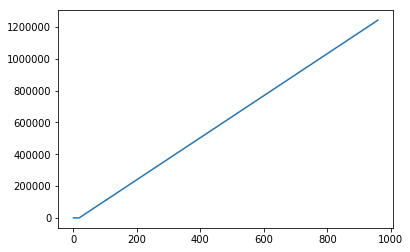

In [33]:
#This plot works
plt.plot(np.arange(0,len(waste_dict[551370000])),waste_dict[551370000])

In [132]:
times = []
masses = []
for i in list(transactions.values())[0]:
    time = str(i).split(',')[0]
    times.append((float(time.strip('('))))
    mass = str(i).split(',')[1]
    masses.append((float(mass.strip(')').strip('('))))

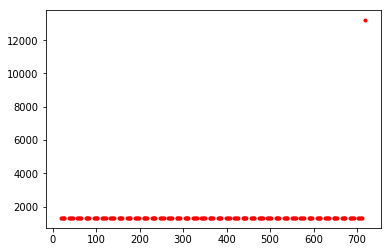

In [133]:
plt.plot(times,masses,'r.')

In [134]:
times1 = times
empty = np.zeros(719)
masses1 = masses
nums = np.arange(0,len(empty))

for j in nums:
    if j not in times1:
        times1.insert(j, j) 
        masses1.insert(j,0)
        #times.append(j)
        print(j)
            

times1

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
20
22
24
26
28
29
30
31
32
33
34
35
36
37
39
41
43
45
47
48
49
50
51
52
53
54
55
56
58
60
62
64
66
67
68
69
70
71
72
73
74
75
77
79
81
83
85
86
87
88
89
90
91
92
93
94
96
98
100
102
104
105
106
107
108
109
110
111
112
113
115
117
119
121
123
124
125
126
127
128
129
130
131
132
134
136
138
140
142
143
144
145
146
147
148
149
150
151
153
155
157
159
161
162
163
164
165
166
167
168
169
170
172
174
176
178
180
181
182
183
184
185
186
187
188
189
191
193
195
197
199
200
201
202
203
204
205
206
207
208
210
212
214
216
218
219
220
221
222
223
224
225
226
227
229
231
233
235
237
238
239
240
241
242
243
244
245
246
248
250
252
254
256
257
258
259
260
261
262
263
264
265
267
269
271
273
275
276
277
278
279
280
281
282
283
284
286
288
290
292
294
295
296
297
298
299
300
301
302
303
305
307
309
311
313
314
315
316
317
318
319
320
321
322
324
326
328
330
332
333
334
335
336
337
338
339
340
341
343
345
347
349
351
352
353
354
355
356
357
358
359
360
362

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19.0,
 20,
 21.0,
 22,
 23.0,
 24,
 25.0,
 26,
 27.0,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38.0,
 39,
 40.0,
 41,
 42.0,
 43,
 44.0,
 45,
 46.0,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57.0,
 58,
 59.0,
 60,
 61.0,
 62,
 63.0,
 64,
 65.0,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76.0,
 77,
 78.0,
 79,
 80.0,
 81,
 82.0,
 83,
 84.0,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95.0,
 96,
 97.0,
 98,
 99.0,
 100,
 101.0,
 102,
 103.0,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114.0,
 115,
 116.0,
 117,
 118.0,
 119,
 120.0,
 121,
 122.0,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133.0,
 134,
 135.0,
 136,
 137.0,
 138,
 139.0,
 140,
 141.0,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152.0,
 153,
 154.0,
 155,
 156.0,
 157,
 158.0,
 159,
 160.0,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171

In [135]:
masses1
times1
#plt.plot(times,masses)

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19.0,
 20,
 21.0,
 22,
 23.0,
 24,
 25.0,
 26,
 27.0,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38.0,
 39,
 40.0,
 41,
 42.0,
 43,
 44.0,
 45,
 46.0,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57.0,
 58,
 59.0,
 60,
 61.0,
 62,
 63.0,
 64,
 65.0,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76.0,
 77,
 78.0,
 79,
 80.0,
 81,
 82.0,
 83,
 84.0,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95.0,
 96,
 97.0,
 98,
 99.0,
 100,
 101.0,
 102,
 103.0,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114.0,
 115,
 116.0,
 117,
 118.0,
 119,
 120.0,
 121,
 122.0,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133.0,
 134,
 135.0,
 136,
 137.0,
 138,
 139.0,
 140,
 141.0,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152.0,
 153,
 154.0,
 155,
 156.0,
 157,
 158.0,
 159,
 160.0,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171

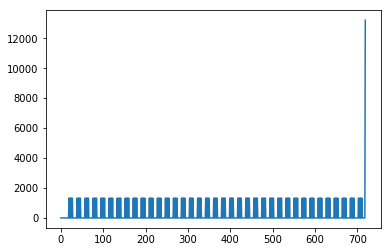

In [136]:
# plots graph where if time isnt listed in original list, mass is 0 at that point.
plt.plot(times1,masses1)